## Factors Affecting Weekly Walmart Sales
__Created by: Tuan Quang (Finn) Pham, Saniya Nadeem__
### A. Introduction:
- An article by Zach Lazzari (2018) that discusses the role of sales in business firms,  argues that sales is the most crucial element for the survival of an organization. Furthermore, it has a significant impact on other aspects of a business such as the firm's overall profit, brand image and most importantly, it reflects customers' perceptions of the organization. 

- In this project, we will be focusing on the weekly sales conditions of Walmart - a global corporation known for its extensive network of stores and diverse products. Specifically, we plan to assess several external factors we believe will have an impact on the number of sales of a company. 

- Throughout this analysis, we hope to aid organizations in making informed decisions and optimizing business operations. From our perspective, with a predictive model of high accuracy level, Walmart will be able to proactively respond to market dynamics, mitigate risks, and capitalize emerging opportunities. Walmart can also use this to improve inventory management, optimize staffing levels, tailor promotional strategies, and enhance overall efficiency. This will help the firm maintain a competitive edge in the retail industry and can also help the firm maximize its profits. 

### B. Methods and Plans:
- __Research question of interest__: What is the weekly sales of Walmart based on the economics conditions and other events that are presented throughout the week?
- __How will we answer our requestion__: We are aiming to build two different regression models: __multiple regression__ and __LASSO regression__. We will later on compare these two models by looking at the __Mean Squared Error__ (which indicates how far off our prediction is from the actual values) and finalize the best model at the end of this report. 
- __The dataset__: Our dataset was published by M. Yasser H. on Kaggle, we present a short glimpse of our dataset below.
- __Variables in use__: We will be using `Holiday_Flag`, `Temperature`, `Fuel Price`, `CPI` and `Unemployment` as our explanatory variables, to help us analyze our sales.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

In [14]:
walmart_dt = pd.read_csv("https://raw.githubusercontent.com/tuanqpham/toy_ds_project/main/Walmart.csv")
walmart_dt.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


- An explanation of the variables (as provided by the onwer of the dataset):
    * `Store`: the store number (encoded as type integers in the dataset).
    * `Date`: the of sales in record.
    * `Weekly_Sales`: the number of sales in that week.
    * `Holiday_Flag`: indicates whether the week was a special holiday (1 = Holiday Week, 0 = Non-holiday week)
    * `Temperature`: temperature recorded in the week (in Farenheit).
    * `Fuel_Price`: cost of fuel in the region.
    * `Unemployment rate`: the unemployment rate
    * `CPI`: the Consumer Price Index.

### C. Assessing our data:
- In this section, we will be cleaning our dataset by only keeping variables we believe are necessary in building our model. We will also be creating visualizations to gain a better understanding of the relationships between the variables: 
- Luckily for us, all column names are readable for the audience which means that there is no need for renaming these variables.
#### C.1. Data cleaning:
- It is important that we remove the rows and columns that are unnecessary for our analysis.
- First. we begin by only dropping unnecessary columns for our analysis. In our case, we will be dropping the store number column as it does not directly affect our sales.

In [15]:
walmart_dt_drop = walmart_dt.drop(["Store"], axis = 1)
walmart_dt_drop.head()

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [16]:
print(walmart_dt_drop.shape)
walmart_dt_new = walmart_dt_drop.dropna()
print(walmart_dt_new.shape)

(6435, 7)
(6435, 7)


Fortunately, our dataset does not contain any missing values. However, we believe it is quite rare in practice to obtain datasets with no missing values.

- In the next step, based on our statistical intuition, we also plan to eliminate any outliers in our data as they negatively affect the accuracy level of our regression model.
- To do this we will first be creating a histogram plot visualizing the distribution of Weekly Sales.

[Text(0.5, 1.0, 'Distribution of Weekly Sales')]

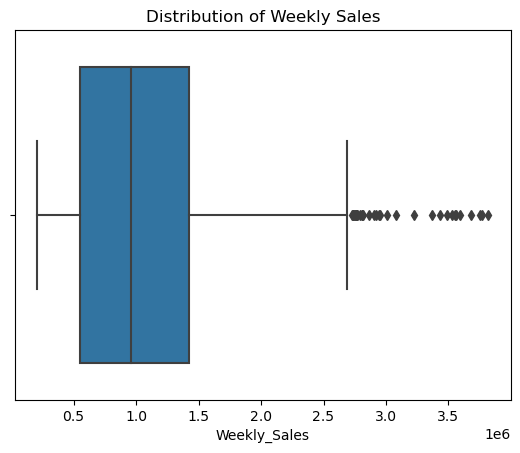

In [17]:
sns.boxplot(data = walmart_dt_new, x = "Weekly_Sales").set(title = "Distribution of Weekly Sales")

From this boxplot, we notice that there are signs of outliers (extreme values outside the normal range) in our dataset. Therefore, we decide to eliminate them in the following step:

In [18]:
#Finding the upper and lower bound of Weekly_Sales
lower = walmart_dt_new["Weekly_Sales"].quantile(0.25)
print(lower)
upper = walmart_dt_new["Weekly_Sales"].quantile(0.75)
print(upper)
iqr = upper - lower

max_bound = upper + (1.5*iqr)
min_bound = lower - (1.5*iqr)

# Setting all the values of Weekly Sales outside of desirable range into missing values.
walmart_dt_new.loc[walmart_dt_new["Weekly_Sales"] > max_bound, "Weekly_Sales"] = np.nan
walmart_dt_new.loc[walmart_dt_new["Weekly_Sales"] < min_bound, "Weekly_Sales"] = np.nan

#Dropping missing values and reset the index
walmart = walmart_dt_new.dropna()
walmart = walmart.reset_index()

553350.105
1420158.66


#### C.2: New variable creation:
- For our analysis, we decided to build regression models with the log of `Weekly_Sales` as the target value rather than using the original value. This is done as the relationship between our weekly sales and other predictor variables are not always linear and using the log allows for a linear relationship.
- Furthermore, using the log allows us to achieve a more constant variance, which makes the data more suitable for regression analysis and makes it easier to interpret.

In [19]:
walmart["Log_WeeklySales"] = np.log(walmart["Weekly_Sales"])
walmart

,index,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Log_WeeklySales
0,0,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,14.312455
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,14.311400
2,2,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,14.292966
3,3,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,14.158907
4,4,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,14.256862
...,...,...,...,...,...,...,...,...,...
6396,6430,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684,13.477481
6397,6431,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667,13.505522
6398,6432,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667,13.506897
6399,6433,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667,13.484400


### D. Building and evaluating our regression models:
#### D.1. Training and Testing Data splitting:
- As we notice in one of our predictors, the variable `Holiday_Flag` is actually a dummy variable. Therefore, when splitting our dataset into training and splitting data’s, we want to ensure that both sets contain the same proportion of weeks recorded as holidays and non-holidays.
- We will be keeping 75% of the data for our training set.

In [20]:
#Splitting the dataset:
holiday = walmart.loc[walmart["Holiday_Flag"] == 1]
non_holiday = walmart.loc[walmart["Holiday_Flag"] == 0]

holiday_train, holiday_test = train_test_split(holiday, test_size = 0.25, random_state = 10)
non_holiday_train, non_holiday_test = train_test_split(non_holiday, test_size = 0.25, random_state = 10)

training_data = pd.concat([holiday_train, non_holiday_train])
testing_data = pd.concat([holiday_test, non_holiday_test])

#### D.2. Visualizations:
- As mentioned above, in this subsection, we will be creating visualizations to have a better understanding of the relationships between the variables. Furthermore, we can check whether our explanatory variables do a good job at predicting the log of weekly sales!
- First, we created boxplots illustrating the log weekly sales in holiday and non-holiday weeks to evaluate whether holiday status makes a difference in weekly market sales.
- By comparing the boxplots, we can visually assess whether there is a noticeable difference in the distribution of log weekly sales between holiday and non-holiday weeks. If the boxplots display distinct characteristics, such as different medians or wider/narrower ranges, it suggests that the holiday status variable may have a significant influence on market sales.

[Text(0.5, 1.0, 'Log Weekly Sales during Non-Holiday Weeks and Holiday Weeks')]

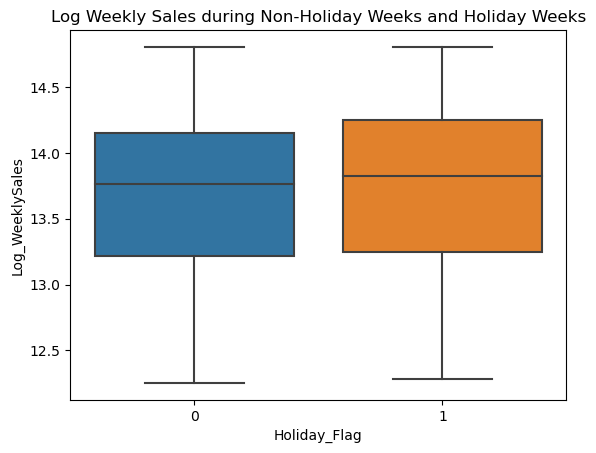

In [21]:
sns.boxplot(data = training_data, y = "Log_WeeklySales", x = "Holiday_Flag").set(title = "Log Weekly Sales during Non-Holiday Weeks and Holiday Weeks")


From the boxplots displayed above, we can see that the log weekly sales during holiday weeks is slightly higher than that during non-holiday weeks. However, given that this difference is not quite significant, we believe it is not the best predictor variable for our model.

- For our quantitative variables, we will first obtain their descriptive statistics:

In [22]:
training_data[["Temperature", "Fuel_Price", "CPI", "Unemployment"]].describe()

,Temperature,Fuel_Price,CPI,Unemployment
count,4800.00000,4800.000000,4800.000000,4800.000000
mean,60.98050,3.367021,171.098244,7.998198
std,18.25877,0.458591,39.390360,1.889282
min,-2.06000,2.472000,126.064000,3.879000
25%,47.95750,2.938000,131.193097,6.891000
50%,63.03000,3.473000,182.258701,7.866000
75%,75.09000,3.741000,212.833640,8.622250
max,100.14000,4.468000,227.232807,14.313000


Then, we create 4 different scatterplots showing the relationships between each of our predictor variables with the log linear weekly sales:

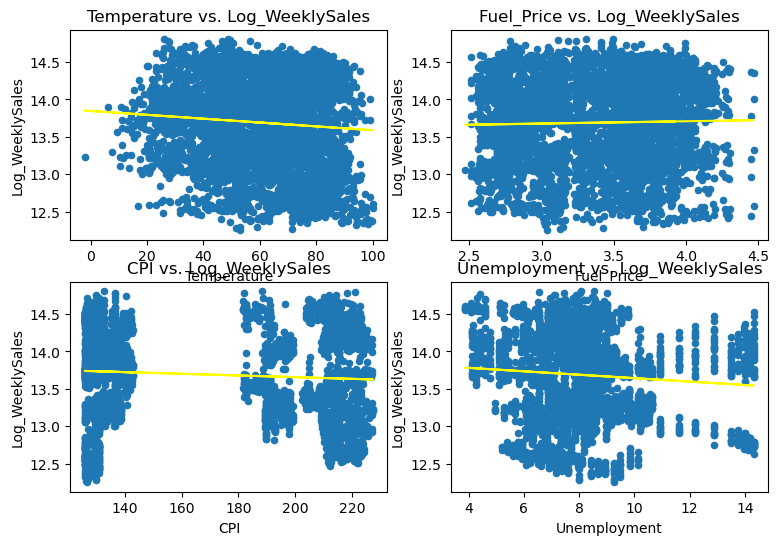

In [23]:
fig, axes = plt.subplots(2, 2, figsize = (9,6))
col_names = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

for a in range(len(col_names)):
    if a < 2:
        training_data.plot.scatter(x = col_names[a], y = "Log_WeeklySales", ax = axes[0, a])
        axes[0, a].set_title(f"{col_names[a]} vs. Log_WeeklySales")
        m,b = np.polyfit(training_data[col_names[a]], training_data["Log_WeeklySales"], 1)
        axes[0, a].plot(training_data[col_names[a]], m*(training_data[col_names[a]]) + b, color = "yellow")
    else:
        training_data.plot.scatter(x = col_names[a], y = "Log_WeeklySales", ax = axes[1, a-2])
        axes[1, a-2].set_title(f"{col_names[a]} vs. Log_WeeklySales")
        m,b = np.polyfit(training_data[col_names[a]], training_data["Log_WeeklySales"], 1)
        axes[1, a-2].plot(training_data[col_names[a]], m*(training_data[col_names[a]]) + b, color = "yellow")


From the above plots, we discovered that there is a very weak to no relationship between the predictor variables and response variable. This suggests the variables in use might not be the best predictors of Walmart weekly sales.

To understand the relationship between the variables numerically, we have obtained the following correlation matrix using colors to demonstrate the strength of the correlation. By using colors to represent the strength of the correlations, we can easily identify the variables that exhibit significant relationships with each other.

This will help us to assess the strength of each variable and determine which ones may be the best predictors of Walmart weekly sales.

<Axes: >

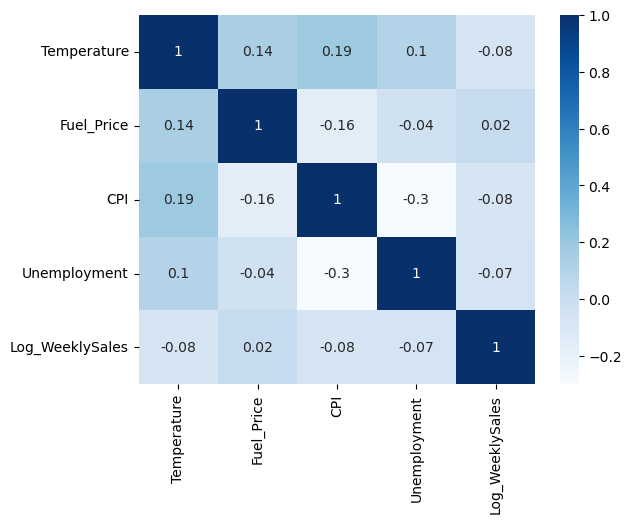

In [24]:
correlation_matrix = round(training_data[["Temperature", "Fuel_Price", "CPI", "Unemployment", "Log_WeeklySales"]].corr(), 2)
sns.heatmap(correlation_matrix, cmap = "Blues", annot = True)

#### D.3. Performing regression and obtain error statistics:
##### __Linear Regression__:
- In this subsection, we will be fitting our linear regression model by using all of the explanatory variables as planned. Then, we will calculate the Mean Squared Error to assess the level of accuracy of our model. 
- The Mean Squared Error is calculated by taking the average of the squared differences between the predicted and actual values.

In [25]:
X_train = training_data[["Temperature", "Fuel_Price", "CPI", "Unemployment", "Holiday_Flag"]]
y_train = training_data["Log_WeeklySales"]
X_test = testing_data[["Temperature", "Fuel_Price", "CPI", "Unemployment", "Holiday_Flag"]]
y_test = testing_data["Log_WeeklySales"]


model = linear_model.LinearRegression()
model.fit(X_train, y_train)
mse_train = mean_squared_error(y_train, model.predict(X_train))
print(mse_train)
mse_test = mean_squared_error(y_test, model.predict(X_test))
print(mse_test)

0.33423595803089307
0.32928753482512235


- From the statistics reported above, the Mean Squared Error of our linear regression model is roughly 0.334 for training data and 0.329 for testing data. 
- In the following code, we will be creating a scatterplot between the values our model predicted and the actual values of the dataset. We have also attempted to generate a linear function that best describes the relationship between the predicted and actual values of log weekly Walmart sales.

Text(0.5, 1.0, 'Relationship between predicted and actual log weekly Walmart Sales')

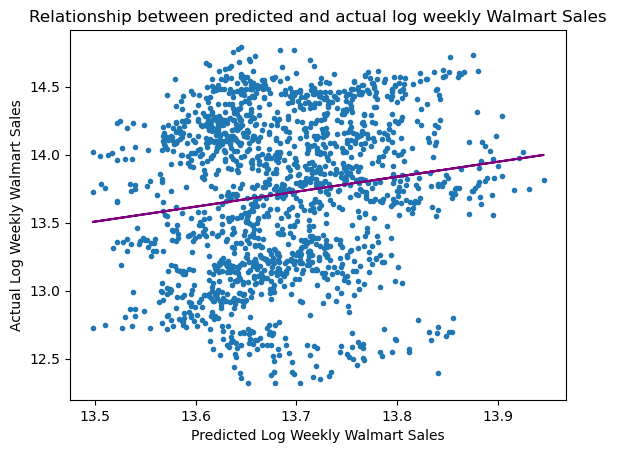

In [26]:
plt.plot(model.predict(X_test), y_test, ".")
m, b = np.polyfit(model.predict(X_test), y_test, 1)
plt.plot(model.predict(X_test), m*model.predict(X_test) + b, color = "purple")
plt.xlabel("Predicted Log Weekly Walmart Sales")
plt.ylabel("Actual Log Weekly Walmart Sales")
plt.title("Relationship between predicted and actual log weekly Walmart Sales")

- From this scatterplot, we notice that the actual values and predicted values have a weak positive correlation. Furthermore, we observe that the points on the graph tend to lie on the $y =x$ graph.

- We have also calculated the specific correlation coefficient between our predicted and actual Weekly Sales.


In [27]:
dt = pd.DataFrame(model.predict(X_test), y_test)
dt.rename(columns = {"Log_WeeklySales": "Actual",
                     0: "Predicted"}).reset_index().corr()


,Log_WeeklySales,Predicted
Log_WeeklySales,1.000000,0.150265
Predicted,0.150265,1.000000


- From the correlation matrix shown above, using linear regression, the and predicted values from our model and the actual values of Log Weekly Sales appear to have a positive correlation yet it seems to be weak.

##### __LASSO Regression__:
- In this part, we attempt to fit the LASSO regression model using the same set of variables as what we did with linear regression. We have also calculated the Lasso coefficients using alpha at a default value of 1.0.
- Similarly, to what we did in Linear regression, we will also be reporting our Mean Squared Error of model when operating on both training and testing data

In [28]:
la_model = linear_model.Lasso()
la_model.fit(X_train, y_train)
dt = pd.Series(dict(zip(list(X_train), la_model.coef_)))
print(dt)
mse_train = mean_squared_error(y_train, la_model.predict(X_train))
print(mse_train)
mse_test = mean_squared_error(y_test, la_model.predict(X_test))
print(mse_test)

Temperature    -0.000000
Fuel_Price      0.000000
CPI            -0.000482
Unemployment   -0.000000
Holiday_Flag    0.000000
dtype: float64
0.33940741648701894
0.3354562166363967


The Mean Squared Error for our training and testing data are approximately 0.339 and 0.335 respectively.

One interesting thing we noticed with our series of Lasso Coefficient is that when alpha is set to be 1.0, `CPI` is the only variable that has a parameter. This somewhat suggests that many of the explanatory variables in use may not have much predicting power.
- We have also created another scatterplot to have a glimpse of the relationship between the predicted and actual values of Log Weekly Sales, similarly to the procedure performed in Linear Regression:


Text(0.5, 1.0, 'Relationship between predicted and actual log weekly Walmart Sales')

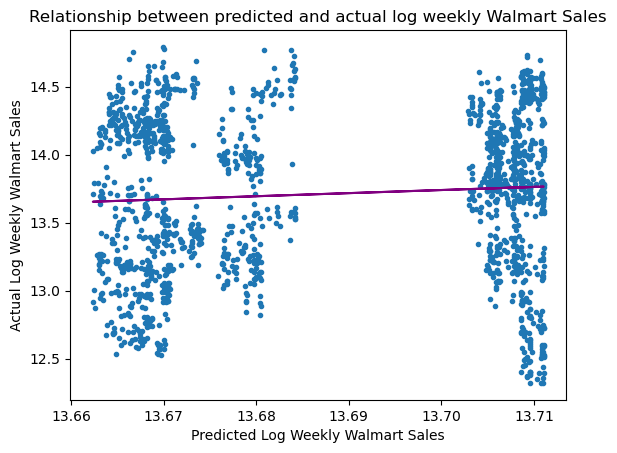

In [29]:
plt.plot(la_model.predict(X_test), y_test, ".")
m,b = np.polyfit(la_model.predict(X_test), y_test, 1)
plt.plot(la_model.predict(X_test), m*la_model.predict(X_test) + b, color = "purple")
plt.xlabel("Predicted Log Weekly Walmart Sales")
plt.ylabel("Actual Log Weekly Walmart Sales")
plt.title("Relationship between predicted and actual log weekly Walmart Sales")

In [30]:
dt = pd.DataFrame(la_model.predict(X_test), y_test)
dt.rename(columns = {"Log_WeeklySales": "Actual",
                     0: "Predicted"}).reset_index().corr()

,Log_WeeklySales,Predicted
Log_WeeklySales,1.000000,0.074542
Predicted,0.074542,1.000000


- The scatterplot above shows us that the relationship between the two variables is not significant and is a very weak positive relationship.

##### Random Forest:


- In this subsection, we will be fitting a Random Forest model into our training and testing data with a maximum depth of 10 layers. Then, we will report our MSE on our training and testing data. 

In [31]:
rdf = RandomForestRegressor(n_estimators = 10,
                           max_depth = 10,
                           random_state = 123)
rdf.fit(X_train, y_train)
mse_train = mean_squared_error(y_train, rdf.predict(X_train))
mse_test = mean_squared_error(y_test, rdf.predict(X_test))

print(mse_train)
print(mse_test)

0.17628490915181605
0.2179451057386171


As observed, our Mean Squared Error for training and testing data using a Random Forest regression model with maximum depth of 10 layers are roughly 0.176 and 0.218 respectively. 
- Next, we have included a plot showing the relationship between the actual and predict values of Log Weekly Sales.

Text(0.5, 1.0, 'Relationship between predicted and actual log weekly Walmart Sales')

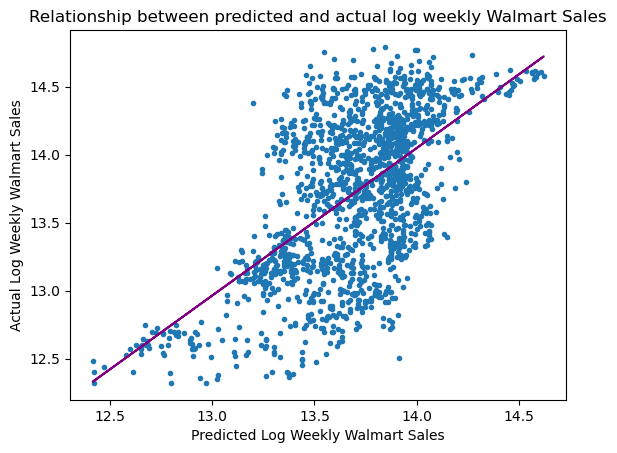

In [23]:
plt.plot(rdf.predict(X_test), y_test, ".")
m,b = np.polyfit(rdf.predict(X_test), y_test,1) 
plt.plot(rdf.predict(X_test), m*rdf.predict(X_test)+b, color = "purple")
plt.xlabel("Predicted Log Weekly Walmart Sales")
plt.ylabel("Actual Log Weekly Walmart Sales")
plt.title("Relationship between predicted and actual log weekly Walmart Sales")

In [24]:
dt = pd.DataFrame(rdf.predict(X_test), y_test)
dt.rename(columns = {"Log_WeeklySales": "Actual",
                     0: "Predicted"}).reset_index().corr()

,Log_WeeklySales,Predicted
Log_WeeklySales,1.000000,0.595946
Predicted,0.595946,1.000000


### E. Discussions and Observations:
- Overall, we have attempted to fit in three different types of models that would help us answer our research question of interest, that is, what is the Weekly Sales at Walmart given several social and economics conditions. The three models we used in our analysis were: multiple linear regression, LASSO regression and random forest.
- We notice that the mean squared error (MSE) on training data and testing data (respectively) after using the three models as follow:
    * Linear Regression: __0.3342__ and __0.3292__
    * LASSO Regression: __0.3394__ and __0.3354__
    * Random Forest: __0.1763__ and __0.2179__
- Based on our observations at the MSE values, we believe that using the Random Forest model with a maximum layer of 10 will yield the highest level of accuaracy when predicting Walmart weekly sales. Howevever, we suspect that there could be potential problems with our Random Forest model is that it might be overfitting as it produces a higher MSE on testing data compared to the one on training data. 
- Another concern we encountered while building the regression models is that the relationships between each of our explanatory variable and the response variable tend to be very weak. This indicates that the variables used in our analysis may not be strong predictors of Walmart's weekly sales. To improve the models' predictive power, we suggest introducing more variables that have more predicting power.


### F. References:
- H, M. Y. (2021, December 26). Walmart dataset. Kaggle. 
    https://www.kaggle.com/datasets/yasserh/walmart-dataset 
- Lazzari, Z. (2018, August 23). The importance of sales in an organization. Bizfluent.
    https://bizfluent.com/the-importance-of-sales-in-an-organization.html 